#  Entraînement d'un modèle de reconnaissance visuelle de la parole simple
 
 Ce notebook guide à travers les étapes d'entraînement d'un modèle VSR (Visual Speech Recognition) simple capable de reconnaître 4 mots français : "oui", "non", "un" et "deux" uniquement à partir des mouvements des lèvres.
 
##  Processus d'entraînement
 
 1. **Chargement des données** : Les images des lèvres collectées pour chaque mot sont chargées depuis les dossiers correspondants.
 
 2. **Prétraitement des images** : Chaque image est redimensionnée à une taille fixe, convertie en niveaux de gris et normalisée pour standardiser l'entrée du modèle.
 
 3. **Organisation en séquences** : Les images sont regroupées en séquences temporelles correspondant à chaque prononciation d'un mot.
 
 4. **Division des données** : Les exemples sont divisés en ensembles d'entraînement (80%) et de test (20%) pour évaluer la capacité de généralisation du modèle.
 
 5. **Entraînement du modèle** : Un réseau de neurones à convolution (CNN) combiné à un réseau récurrent (LSTM) est entraîné pour classifier les mouvements des lèvres.
 
 6. **Évaluation** : Le modèle est évalué sur l'ensemble de test pour mesurer sa précision.
 
 7. **Test en temps réel** : Une fonction permet de tester le modèle avec de nouveaux enregistrements vidéo.

##  Choix du modèle et architecture
 
 Pour ce projet, nous utilisons une architecture CNN+LSTM spécialement adaptée à la VSR. Voici pourquoi ce choix est approprié :
 
  Pourquoi une architecture CNN+LSTM ?
 
 1. **Extraction des caractéristiques spatiales** : Les réseaux CNN sont excellents pour extraire des caractéristiques visuelles pertinentes à partir d'images. Ils peuvent identifier les formes et mouvements des lèvres.
 
 2. **Modélisation des séquences temporelles** : Les LSTM (Long Short-Term Memory) sont conçus pour capturer les dépendances temporelles dans des séquences, ce qui est crucial pour comprendre les mouvements des lèvres qui se déroulent dans le temps.
 
 3. **Robustesse aux variations** : Cette architecture hybride peut s'adapter à différents locuteurs et conditions d'enregistrement.
 
##  Architecture du modèle
 
 Notre modèle utilise la configuration suivante :
 
 - **Entrée** : Séquence d'images de lèvres (30 frames de taille 64x64x1 pour 1 seconde à 30 FPS)
 - **Couches CNN** : Extraction de caractéristiques spatiales avec 3 blocs convolutifs
 - **TimeDistributed** : Application du CNN à chaque frame de la séquence
 - **LSTM** : Modélisation des dépendances temporelles avec 2 couches bidirectionnelles
 - **Dense** : Couches entièrement connectées pour la classification
 - **Sortie** : 4 neurones (un pour chaque mot) avec fonction softmax
 
##  Hyperparamètres
 
 - **Taux d'apprentissage** : 0.001 avec décroissance
 - **Taille du batch** : 16 (adapté à la quantité de données disponible)
 - **Nombre d'époques** : 100 avec early stopping
 - **Optimiseur** : Adam (efficace pour les réseaux profonds)
 - **Fonction de perte** : Entropie croisée catégorielle

#  Importation des bibliothèques


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pickle
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, TimeDistributed
from tensorflow.keras.layers import LSTM, Bidirectional, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tqdm.notebook import tqdm
import random

# Configuration de matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)

print("Bibliothèques importées avec succès !")



Bibliothèques importées avec succès !


## Configuration des paramètres

In [6]:
# Paramètres globaux
img_size = 64                # Taille des images redimensionnées
max_sequence_length = 30     # Nombre maximum d'images par séquence (1 seconde * 30 fps)
batch_size = 16              # Taille des batchs pour l'entraînement
epochs = 100                 # Nombre maximal d'époques
validation_split = 0.2       # Pourcentage de données pour la validation
random_seed = 42             # Pour la reproductibilité

# Chemins des dossiers
lip_frames_dir = "../data/lip_frames"
processed_dir = "../data/processed"
models_dir = "../models"

# Créer les dossiers s'ils n'existent pas
os.makedirs(processed_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

# Mots cibles
target_words = ["oui", "non", "un", "deux"]

print(f"Configuration terminée ! Nous allons traiter les mots suivants : {target_words}")

Configuration terminée ! Nous allons traiter les mots suivants : ['oui', 'non', 'un', 'deux']


## Chargement et préparation des données

In [7]:
def load_and_preprocess_sequence(sequence_dir, max_length=max_sequence_length):
    """
    Charge et prétraite une séquence d'images de lèvres.
    
    Args:
        sequence_dir: Chemin vers le dossier contenant les images d'une séquence
        max_length: Nombre maximum d'images dans la séquence
    
    Returns:
        np.array: Séquence prétraitée de forme (max_length, img_size, img_size, 1)
    """
    # Obtenir toutes les images de la séquence
    image_files = sorted(glob(os.path.join(sequence_dir, "*.png")))
    
    # Vérifier s'il y a assez d'images
    if len(image_files) < 5:  # Au moins 5 frames pour une séquence valide
        return None
    
    # Charger et prétraiter chaque image
    processed_images = []
    
    for img_file in image_files[:max_length]:
        # Charger l'image
        img = cv2.imread(img_file)
        
        # Convertir en niveaux de gris
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Redimensionner
        resized = cv2.resize(gray, (img_size, img_size))
        
        # Normaliser les valeurs entre 0 et 1
        normalized = resized / 255.0
        
        # Ajouter à la liste
        processed_images.append(normalized)
    
    # Padding: si moins d'images que max_length, ajouter des images noires
    if len(processed_images) < max_length:
        padding = [np.zeros((img_size, img_size)) for _ in range(max_length - len(processed_images))]
        processed_images.extend(padding)
    
    # Convertir en tableau numpy et ajouter la dimension des canaux
    sequence = np.array(processed_images).reshape(max_length, img_size, img_size, 1)
    
    return sequence
def load_data():
    """
    Charge toutes les séquences d'images et prépare les données d'entraînement.
    
    Returns:
        tuple: (X, y) avec X les séquences d'images et y les étiquettes
    """
    sequences = []
    labels = []
    
    print("Chargement et prétraitement des données...")
    
    for word_idx, word in enumerate(target_words):
        word_dir = os.path.join(lip_frames_dir, word)
        
        if not os.path.isdir(word_dir):
            print(f"ATTENTION: Le dossier {word_dir} n'existe pas !")
            continue
        
        # Identifier les séquences uniques par leur préfixe
        sequence_prefixes = set()
        for file in os.listdir(word_dir):
            if file.endswith('.png'):
                # Format attendu: mot_XX_YYY.png où XX est l'indice de séquence
                parts = file.split('_')
                if len(parts) >= 2:
                    prefix = f"{parts[0]}_{parts[1]}"
                    sequence_prefixes.add(prefix)
        
        print(f"Traitement de {len(sequence_prefixes)} séquences pour le mot '{word}'...")
        
        for prefix in tqdm(sequence_prefixes):
            # Obtenir tous les fichiers pour cette séquence
            sequence_files = [f for f in os.listdir(word_dir) if f.startswith(prefix) and f.endswith('.png')]
            
            if len(sequence_files) >= 5:  # Seulement les séquences avec au moins 5 images
                # Créer un dossier temporaire pour cette séquence
                temp_dir = os.path.join(processed_dir, "temp_sequence")
                os.makedirs(temp_dir, exist_ok=True)
                
                # Copier les fichiers dans le dossier temporaire
                for file in sequence_files:
                    src_path = os.path.join(word_dir, file)
                    dst_path = os.path.join(temp_dir, file)
                    # Utiliser un lien symbolique ou une copie
                    try:
                        os.symlink(src_path, dst_path)
                    except:
                        # Si les liens symboliques ne sont pas supportés, copier
                        import shutil
                        shutil.copy2(src_path, dst_path)
                
                # Charger et prétraiter la séquence
                sequence = load_and_preprocess_sequence(temp_dir)
                
                # Nettoyer le dossier temporaire
                for file in os.listdir(temp_dir):
                    os.remove(os.path.join(temp_dir, file))
                os.rmdir(temp_dir)
                
                if sequence is not None:
                    sequences.append(sequence)
                    labels.append(word_idx)
    
    # Convertir en tableaux numpy
    X = np.array(sequences)
    y = np.array(labels)
    
    # Encoder les étiquettes
    y_encoded = to_categorical(y, num_classes=len(target_words))
    
    return X, y_encoded

In [8]:
# Charger les données
X, y = load_data()

print(f"Données chargées : {X.shape[0]} séquences, {X.shape[1]} frames par séquence")
print(f"Forme des données : {X.shape}")


Chargement et prétraitement des données...
Traitement de 10 séquences pour le mot 'oui'...


  0%|          | 0/10 [00:00<?, ?it/s]

Traitement de 10 séquences pour le mot 'non'...


  0%|          | 0/10 [00:00<?, ?it/s]

Traitement de 10 séquences pour le mot 'un'...


  0%|          | 0/10 [00:00<?, ?it/s]

Traitement de 10 séquences pour le mot 'deux'...


  0%|          | 0/10 [00:00<?, ?it/s]

Données chargées : 40 séquences, 30 frames par séquence
Forme des données : (40, 30, 64, 64, 1)


## Division des données en ensembles d'entraînement et de test

In [9]:
# Diviser en ensembles d'entraînement et de test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=validation_split, random_state=random_seed, stratify=y.argmax(axis=1)
)

print(f"Ensemble d'entraînement : {X_train.shape[0]} exemples")
print(f"Ensemble de test : {X_test.shape[0]} exemples")

# Vérifier la distribution des classes
train_distribution = {
    target_words[i]: np.sum(y_train.argmax(axis=1) == i) 
    for i in range(len(target_words))
}
test_distribution = {
    target_words[i]: np.sum(y_test.argmax(axis=1) == i) 
    for i in range(len(target_words))
}

print("\nDistribution des classes :")
print(f"Entraînement : {train_distribution}")
print(f"Test : {test_distribution}")

Ensemble d'entraînement : 32 exemples
Ensemble de test : 8 exemples

Distribution des classes :
Entraînement : {'oui': 8, 'non': 8, 'un': 8, 'deux': 8}
Test : {'oui': 2, 'non': 2, 'un': 2, 'deux': 2}


# Augmentation du jeu de données

In [10]:
# Ajout d'une fonction d'augmentation de données intensive
def apply_augmentation(X_data):
    """
    Applique une augmentation de données intensive aux séquences d'images.
    
    Args:
        X_data: Données originales de forme [samples, frames, height, width, channels]
    
    Returns:
        X_augmented: Données augmentées
    """
    print("Application de l'augmentation de données...")
    X_augmented = []
    y_augmented = []
    
    # Pour chaque séquence dans les données
    for i in range(len(X_data)):
        sequence = X_data[i]
        original_label = y_train[i]
        
        # Ajouter la séquence originale
        X_augmented.append(sequence)
        y_augmented.append(original_label)
        
        # Créer 5 versions augmentées (multiplier dataset par 6)
        for j in range(5):
            aug_sequence = np.zeros_like(sequence)
            
            # Appliquer différentes augmentations à chaque frame
            for f in range(sequence.shape[0]):
                frame = sequence[f, :, :, 0]
                
                # Rotation aléatoire légère (-15 à +15 degrés)
                angle = np.random.uniform(-15, 15)
                M = cv2.getRotationMatrix2D((img_size//2, img_size//2), angle, 1)
                rotated = cv2.warpAffine(frame, M, (img_size, img_size))
                
                # Variation de luminosité
                brightness = np.random.uniform(0.7, 1.3)
                brightened = np.clip(rotated * brightness, 0, 1)
                
                # Légère variation de zoom (90% à 110%)
                zoom = np.random.uniform(0.9, 1.1)
                h, w = brightened.shape
                zh = int(np.round(h * zoom))
                zw = int(np.round(w * zoom))
                
                # Assurer que les dimensions sont dans les limites
                zh = min(zh, h)
                zw = min(zw, w)
                
                # Appliquer le zoom
                top = (h - zh) // 2
                left = (w - zw) // 2
                
                # Si zoom > 1, on rogne l'image
                if zoom > 1:
                    brightened = brightened[top:top+zh, left:left+zw]
                    zoomed = cv2.resize(brightened, (img_size, img_size))
                else:  # Si zoom < 1, on ajoute du padding
                    zoomed = np.zeros((img_size, img_size))
                    zoomed[top:top+zh, left:left+zw] = cv2.resize(brightened, (zw, zh))
                
                # Léger décalage horizontal et vertical
                tx = np.random.randint(-3, 4)
                ty = np.random.randint(-2, 3)
                T = np.float32([[1, 0, tx], [0, 1, ty]])
                shifted = cv2.warpAffine(zoomed, T, (img_size, img_size))
                
                # Ajout d'un peu de bruit gaussien
                noise = np.random.normal(0, 0.02, shifted.shape)
                noisy = np.clip(shifted + noise, 0, 1)
                
                # Sauvegarder la frame augmentée
                aug_sequence[f, :, :, 0] = noisy
            
            # Ajouter la séquence augmentée
            X_augmented.append(aug_sequence)
            y_augmented.append(original_label)
    
    # Convertir en tableaux numpy
    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)
    
    print(f"Données augmentées : {len(X_augmented)} séquences (× {len(X_augmented)/len(X_data)})")
    return X_augmented, y_augmented

## Définition du modèle CNN+LSTM


In [11]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2

In [12]:
def create_model():
    """
    Crée un modèle CNN+LSTM ultra-léger adapté aux très petits datasets.
    
    Returns:
        model: Modèle Keras compilé
    """
    # Importer les modules nécessaires
    from tensorflow.keras.layers import AveragePooling2D
    from tensorflow.keras.regularizers import l2
    
    # Paramètres
    input_shape = (max_sequence_length, img_size, img_size, 1)
    num_classes = len(target_words)
    
    # Couche d'entrée
    inputs = Input(shape=input_shape)
    
    # Réduire les dimensions spatiales immédiatement (2x2 pooling)
    pooled = TimeDistributed(AveragePooling2D(pool_size=(2, 2)))(inputs)
    
    # Module CNN minimaliste - une seule couche avec peu de filtres
    cnn = TimeDistributed(Conv2D(8, kernel_size=(5, 5), activation='relu', 
                               padding='same',
                               kernel_regularizer=l2(0.001)))(pooled)
    cnn = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(cnn)
    cnn = TimeDistributed(Dropout(0.5))(cnn)
    
    # Seconde couche convolutive (très peu de filtres)
    cnn = TimeDistributed(Conv2D(16, kernel_size=(3, 3), activation='relu',
                               padding='same',
                               kernel_regularizer=l2(0.001)))(cnn)
    cnn = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(cnn)
    cnn = TimeDistributed(Dropout(0.5))(cnn)
    
    # Aplatir
    cnn = TimeDistributed(Flatten())(cnn)
    
    # Version ultra-simplifiée: agrégation temporelle par moyenne au lieu de LSTM
    # C'est beaucoup moins sensible au surapprentissage
    pooled_features = tf.keras.layers.GlobalAveragePooling1D()(cnn)
    

    # Couche de classification minimaliste
    dense = Dense(16, activation='relu', kernel_regularizer=l2(0.002))(pooled_features)
    dense = Dropout(0.5)(dense)
    outputs = Dense(num_classes, activation='softmax')(dense)
    
    # Créer et compiler le modèle
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0002),  # Learning rate très bas
        metrics=['accuracy']
    )
    
    return model

In [25]:
# Créer le modèle
model = create_model()
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 30, 64, 64, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_19                  │ (None, 30, 32, 32, 1)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_20                  │ (None, 30, 32, 32, 8)       │             208 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_21                  │ (None, 30, 16, 16, 8)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_22                  │ (None, 30, 16, 16, 8)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_23                  │ (None, 30, 16, 16, 16)      │           1,168 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_24                  │ (None, 30, 8, 8, 16)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_25                  │ (None, 30, 8, 8, 16)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_26                  │ (None, 30, 1024)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │          16,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │              68 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,844 (69.70 KB)

 Trainable params: 17,844 (69.70 KB)

 Non-trainable params: 0 (0.00 B)

 ## Entraînement du modèle

In [13]:
# Paramètres ajustés pour petit dataset
batch_size = 4  # Très petit batch size
epochs = 150    # Plus d'époques (avec early stopping)

# Augmenter les données d'entraînement
X_train_aug, y_train_aug = apply_augmentation(X_train)

Application de l'augmentation de données...
Données augmentées : 192 séquences (× 6.0)


In [14]:
print(len(X_train_aug))


192


In [30]:
# Modifier les callbacks pour un entraînement plus patient
checkpoint = ModelCheckpoint(
    os.path.join(models_dir, 'vsr_model_best.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=40,  # Patience plus élevée
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Réduction plus agressive
    patience=15,  # Attendre plus longtemps
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Entraînement du modèle
print("Entraînement du modèle en cours...")
history = model.fit(
    X_train_aug, y_train_aug,  # Utiliser les données augmentées
    validation_data=(X_test, y_test),  # Validation sur données originales
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1,
    class_weight={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}  # Équilibrer si nécessaire
)

Entraînement du modèle en cours...
Epoch 1/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1970 - loss: 1.4628
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to ../models\vsr_model_best.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.1983 - loss: 1.4626 - val_accuracy: 0.2500 - val_loss: 1.4513 - learning_rate: 2.0000e-04
Epoch 2/150
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1887 - loss: 1.4616
Epoch 2: val_accuracy did not improve from 0.25000
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.1908 - loss: 1.4612 - val_accuracy: 0.2500 - val_loss: 1.4436 - learning_rate: 2.0000e-04
Epoch 3/150
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2083 - loss: 1.4456
Epoch 3: val_accuracy did not improve from 0.25000
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2108 - loss: 1.4454 - val_accuracy: 0.2500 - val_loss: 1.4379 - learning_rate: 2.0000e-04
Epoch 4/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2968 - loss: 1.4364
Epoch 4: val_accuracy did not improve from 0.25000
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.2960 - loss: 1.4365 - val_accuracy: 0.2500 - val_loss: 1.4336 - learning_rate: 2.0000e-04
Epoch 5/150


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.3439 - loss: 1.4163 - val_accuracy: 0.5000 - val_loss: 1.4193 - learning_rate: 2.0000e-04
Epoch 12/150
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3056 - loss: 1.4171
Epoch 12: val_accuracy did not improve from 0.50000
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3056 - loss: 1.4171 - val_accuracy: 0.2500 - val_loss: 1.4176 - learning_rate: 2.0000e-04
Epoch 13/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3434 - loss: 1.4126
Epoch 13: val_accuracy did not improve from 0.50000
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.3431 - loss: 1.4126 - val_accuracy: 0.2500 - val_loss: 1.4162 - learning_rate: 2.0000e-04
Epoch 14/150
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2777 - loss: 1.4121
Epoch 14: val_accuracy did not improve from 0.50000
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2762 - loss: 1.4123 - val_accuracy: 0.2500 - val_loss: 1.4150 - learning_rate: 2.0000e-04
Epoch 1

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.3246 - loss: 1.3915 - val_accuracy: 0.7500 - val_loss: 1.3960 - learning_rate: 2.0000e-04
Epoch 29/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3383 - loss: 1.3904
Epoch 29: val_accuracy did not improve from 0.75000
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.3381 - loss: 1.3905 - val_accuracy: 0.5000 - val_loss: 1.3939 - learning_rate: 2.0000e-04
Epoch 30/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2857 - loss: 1.3984
Epoch 30: val_accuracy did not improve from 0.75000
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.2863 - loss: 1.3983 - val_accuracy: 0.5000 - val_loss: 1.3923 - learning_rate: 2.0000e-04
Epoch 31/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3778 - loss: 1.3881
Epoch 31: val_accuracy did not improve from 0.75000
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.3760 - loss: 1.3882 - val_accuracy: 0.5000 - val_loss: 1.3880 - learning_rate: 2.0000e-04
Epoch 3

## Visualisation de l'entraînement

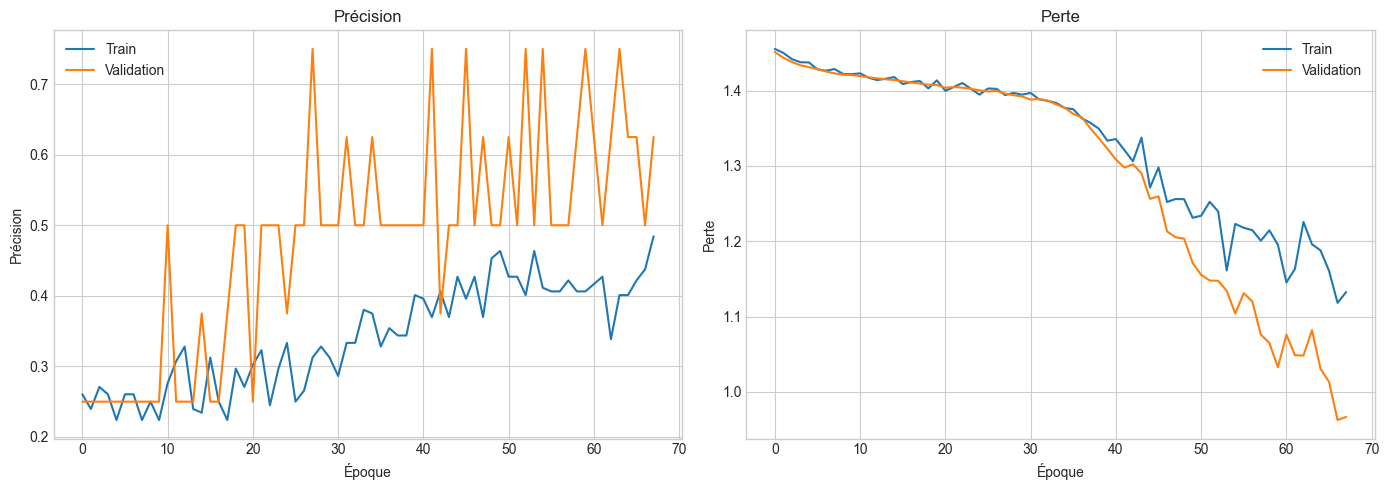

In [31]:
# Tracer les courbes d'apprentissage
plt.figure(figsize=(14, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Précision')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Évaluation du modèle

Évaluation du modèle sur l'ensemble de test...
Précision sur le test : 0.7500
Perte sur le test : 1.3960
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step

Rapport de classification :
              precision    recall  f1-score   support

         oui       0.50      1.00      0.67         2
         non       0.00      0.00      0.00         2
          un       1.00      1.00      1.00         2
        deux       1.00      1.00      1.00         2

    accuracy                           0.75         8
   macro avg       0.62      0.75      0.67         8
weighted avg       0.62      0.75      0.67         8



C:\Users\av35v\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\av35v\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\av35v\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

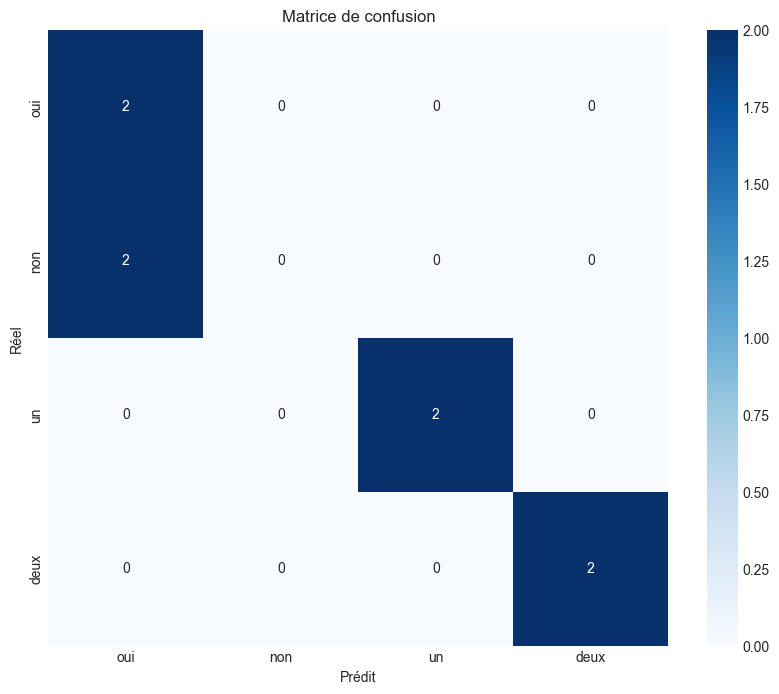

In [32]:
# Évaluer sur l'ensemble de test
print("Évaluation du modèle sur l'ensemble de test...")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Précision sur le test : {test_acc:.4f}")
print(f"Perte sur le test : {test_loss:.4f}")

# Faire des prédictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Rapport de classification
print("\nRapport de classification :")
print(classification_report(y_true, y_pred, target_names=target_words))

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_words, yticklabels=target_words)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()



 ## Sauvegarde du modèle

In [33]:
# Sauvegarder le modèle
model_path = os.path.join(models_dir, 'vsr_model_final.h5')
model.save(model_path)

# Sauvegarder les métadonnées du modèle
model_metadata = {
    'target_words': target_words,
    'img_size': img_size,
    'max_sequence_length': max_sequence_length
}

metadata_path = os.path.join(models_dir, 'vsr_model_metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(model_metadata, f)

print(f"Modèle sauvegardé dans {model_path}")
print(f"Métadonnées sauvegardées dans {metadata_path}")

Modèle sauvegardé dans ../models\vsr_model_final.h5
Métadonnées sauvegardées dans ../models\vsr_model_metadata.pkl


# Test en temps réel avec la webcam


In [17]:
import cv2
import dlib
import time
from imutils import face_utils

# Charger le détecteur et le prédicteur de visage
detector = dlib.get_frontal_face_detector()
predictor_path = "../models/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(predictor_path)
# Charger le modèle VSR
vsr_model_path = "../models/vsr_model_final.h5"
model = load_model(vsr_model_path)
def extract_lip_region(frame):
    """
    Extrait la région des lèvres d'une image.
    """
    # Convertir en niveaux de gris pour la détection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Détecter les visages
    faces = detector(gray, 0)
    
    if len(faces) == 0:
        return None
    
    # Prendre le premier visage détecté
    face = faces[0]
    
    # Prédire les points de repère
    shape = predictor(gray, face)
    shape = face_utils.shape_to_np(shape)
    
    # Les points des lèvres sont les points 48-68 dans le modèle à 68 points
    lips_points = shape[48:68]
    
    # Calculer le rectangle englobant pour les lèvres
    x, y = lips_points.min(axis=0)
    w, h = lips_points.max(axis=0) - lips_points.min(axis=0)
    
    # Ajouter une marge
    margin = 10
    x = max(0, x - margin)
    y = max(0, y - margin)
    w = min(frame.shape[1] - x, w + 2 * margin)
    h = min(frame.shape[0] - y, h + 2 * margin)
    
    # Extraire la région des lèvres
    lip_region = frame[y:y+h, x:x+w]
    
    return lip_region

def preprocess_lip_region(lip_region):
    """
    Prétraite une région de lèvres pour la prédiction.
    """
    if lip_region is None:
        return None
    
    # Convertir en niveaux de gris
    gray = cv2.cvtColor(lip_region, cv2.COLOR_BGR2GRAY)
    
    # Redimensionner
    resized = cv2.resize(gray, (img_size, img_size))
    
    # Normaliser
    normalized = resized / 255.0
    
    # Ajouter les dimensions pour le modèle
    processed = normalized.reshape(1, img_size, img_size, 1)
    
    return processed

def test_model_on_webcam():
    """
    Teste le modèle VSR en temps réel avec la webcam.
    """
    # Initialiser la webcam
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    # Paramètres
    sequence_length = max_sequence_length
    frame_rate = 30
    duration = sequence_length / frame_rate  # environ 1 seconde
    
    print(f"Préparez-vous à prononcer un mot...\nL'enregistrement commencera dans 3 secondes...")
    time.sleep(3)
    
    # Collecte des frames
    lip_frames = []
    start_time = time.time()
    
    print(f"Enregistrement en cours (environ {duration:.1f} secondes)...")
    
    while len(lip_frames) < sequence_length and time.time() - start_time < duration + 1:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Extraire la région des lèvres
        lip_region = extract_lip_region(frame)
        
        if lip_region is not None:
            # Prétraiter
            processed_lip = preprocess_lip_region(lip_region)
            lip_frames.append(processed_lip.squeeze())
            
            # Afficher le frame avec la région des lèvres mise en évidence
            cv2.imshow('Webcam - Press Q to quit', frame)
            
        # Quitter si 'q' est pressé
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Libérer la webcam
    cap.release()
    cv2.destroyAllWindows()
    
    print("Enregistrement terminé")
    
    # Vérifier s'il y a assez de frames
    if len(lip_frames) < 5:
        print("Pas assez d'images de lèvres détectées. Veuillez réessayer.")
        return
    
    # Préparer la séquence pour le modèle
    # Padding si nécessaire
    if len(lip_frames) < sequence_length:
        padding = [np.zeros((img_size, img_size)) for _ in range(sequence_length - len(lip_frames))]
        lip_frames.extend(padding)
    
    # Limiter à sequence_length frames
    lip_frames = lip_frames[:sequence_length]
    
    # Convertir en tableau numpy
    lip_sequence = np.array(lip_frames).reshape(1, sequence_length, img_size, img_size, 1)
    
    # Prédiction
    prediction = model.predict(lip_sequence)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class]
    
    # Afficher le résultat
    print(f"\nMot prédit : {target_words[predicted_class]} (confiance: {confidence:.2f})")
    
    # Afficher toutes les probabilités
    print("\nProbabilités pour chaque mot :")
    for i, word in enumerate(target_words):
        print(f"  {word}: {prediction[0][i]:.4f}")
    
    # Visualiser quelques frames de la séquence
    plt.figure(figsize=(15, 5))
    num_display = min(6, len(lip_frames))
    indices = np.linspace(0, len(lip_frames)-1, num_display, dtype=int)
    
    for i, idx in enumerate(indices):
        plt.subplot(1, num_display, i+1)
        plt.imshow(lip_frames[idx], cmap='gray')
        plt.title(f"Frame {idx+1}")
        plt.axis('off')
    
    plt.suptitle(f"Prédiction: {target_words[predicted_class]} ({confidence:.2f})")
    plt.tight_layout()
    plt.show()
    
    return target_words[predicted_class], confidence

Préparez-vous à prononcer un mot...
L'enregistrement commencera dans 3 secondes...
Enregistrement en cours (environ 1.0 secondes)...
Enregistrement terminé
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Mot prédit : oui (confiance: 0.29)

Probabilités pour chaque mot :
  oui: 0.2909
  non: 0.2283
  un: 0.2093
  deux: 0.2716


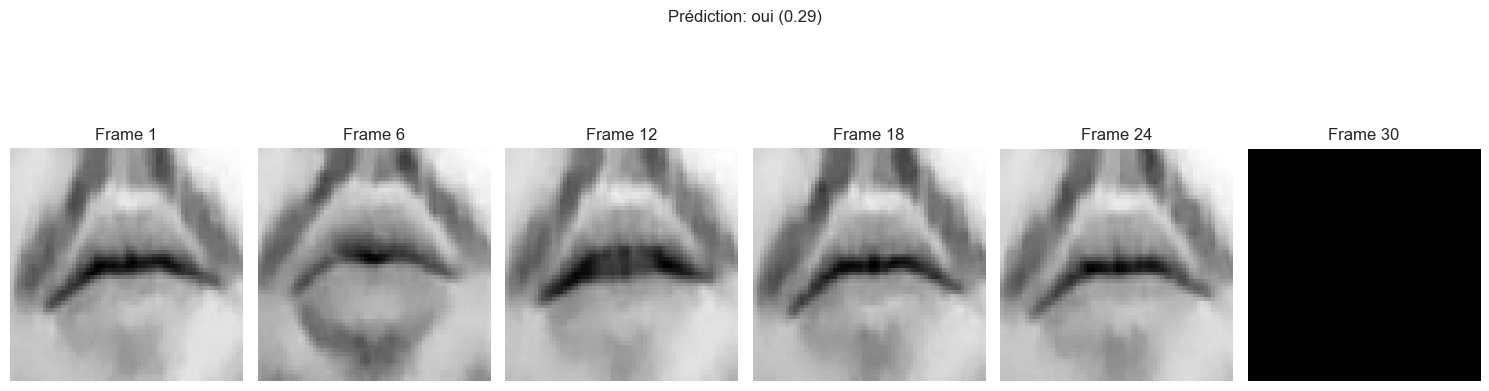

('oui', 0.29087582)

In [18]:
test_model_on_webcam()


 ## Test interactif avec l'utilisateur

In [19]:
def interactive_test(num_tests=5):
    """
    Effectue plusieurs tests avec retour de l'utilisateur.
    """
    results = []
    
    for i in range(num_tests):
        print(f"\n=== Test {i+1}/{num_tests} ===")
        word = input("Quel mot allez-vous prononcer ? (oui/non/un/deux) : ")
        
        if word not in target_words:
            print(f"Attention: '{word}' n'est pas dans la liste des mots reconnus {target_words}")
        
        # Test avec la webcam
        predicted_word, confidence = test_model_on_webcam()
        
        # Enregistrer le résultat
        correct = word == predicted_word
        results.append({
            'actual': word,
            'predicted': predicted_word,
            'confidence': confidence,
            'correct': correct
        })
        
        # Afficher le résultat
        print(f"Mot prononcé: {word}")
        print(f"Mot prédit: {predicted_word} (confiance: {confidence:.2f})")
        print(f"Résultat: {'Correct' if correct else 'Incorrect'}")
    
    # Calculer et afficher les statistiques
    accuracy = sum(r['correct'] for r in results) / len(results)
    print(f"\n=== Résultats finaux ===")
    print(f"Précision: {accuracy:.0%} ({sum(r['correct'] for r in results)}/{len(results)})")
    
    # Matrice de confusion
    true_labels = [target_words.index(r['actual']) if r['actual'] in target_words else -1 for r in results]
    pred_labels = [target_words.index(r['predicted']) for r in results]
    
    # Filtrer les étiquettes valides
    valid_indices = [i for i, label in enumerate(true_labels) if label != -1]
    true_filtered = [true_labels[i] for i in valid_indices]
    pred_filtered = [pred_labels[i] for i in valid_indices]
    
    if valid_indices:
        cm = confusion_matrix(true_filtered, pred_filtered, labels=range(len(target_words)))
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_words, yticklabels=target_words)
        plt.xlabel('Prédit')
        plt.ylabel('Réel')
        plt.title('Matrice de confusion des tests')
        plt.show()
    
    return results


=== Test 1/4 ===


Quel mot allez-vous prononcer ? (oui/non/un/deux) :  non


Préparez-vous à prononcer un mot...
L'enregistrement commencera dans 3 secondes...
Enregistrement en cours (environ 1.0 secondes)...
Enregistrement terminé
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Mot prédit : oui (confiance: 0.29)

Probabilités pour chaque mot :
  oui: 0.2871
  non: 0.2303
  un: 0.2119
  deux: 0.2707


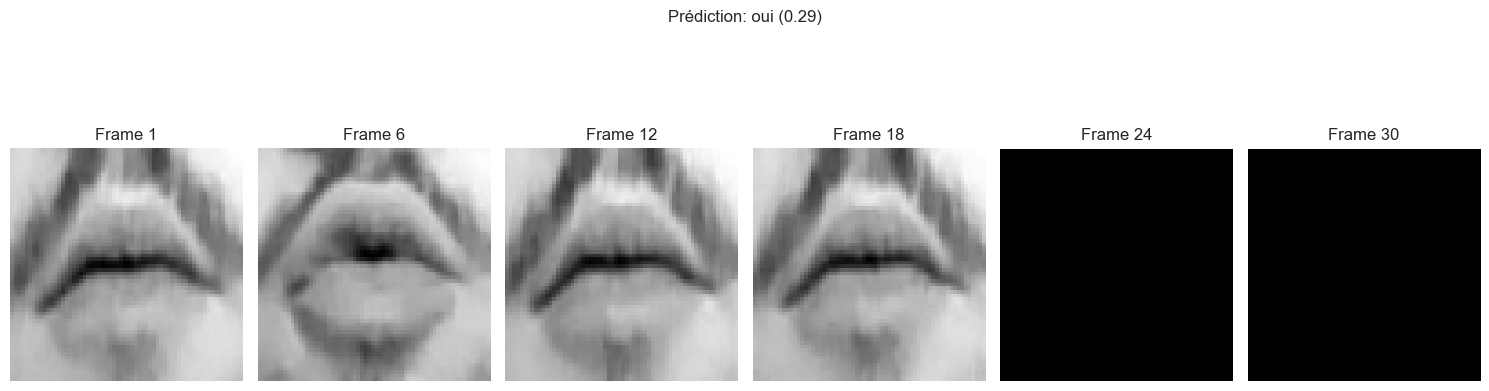

Mot prononcé: non
Mot prédit: oui (confiance: 0.29)
Résultat: Incorrect

=== Test 2/4 ===


Quel mot allez-vous prononcer ? (oui/non/un/deux) :  un


Préparez-vous à prononcer un mot...
L'enregistrement commencera dans 3 secondes...
Enregistrement en cours (environ 1.0 secondes)...
Enregistrement terminé
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Mot prédit : oui (confiance: 0.29)

Probabilités pour chaque mot :
  oui: 0.2857
  non: 0.2246
  un: 0.2191
  deux: 0.2705


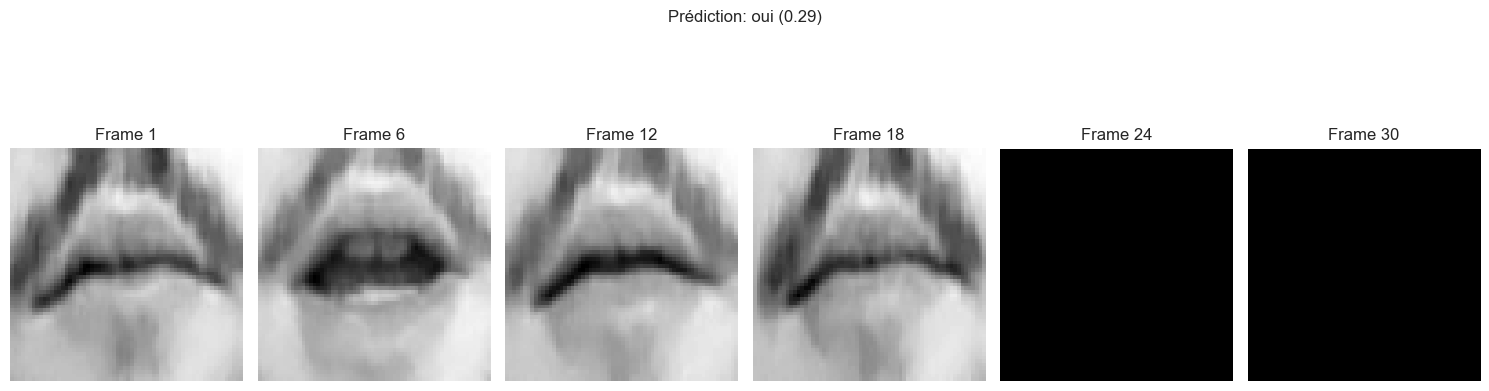

Mot prononcé: un
Mot prédit: oui (confiance: 0.29)
Résultat: Incorrect

=== Test 3/4 ===


Quel mot allez-vous prononcer ? (oui/non/un/deux) :  exit


Attention: 'exit' n'est pas dans la liste des mots reconnus ['oui', 'non', 'un', 'deux']
Préparez-vous à prononcer un mot...
L'enregistrement commencera dans 3 secondes...


KeyboardInterrupt: 

In [20]:
# Pour lancer des tests interactifs
interactivenon_test(num_tests=4)

 ## Visualisation avancée du modèle

In [21]:
def visualize_feature_maps(sequence):
    """Visualise les cartes de caractéristiques du modèle pour une séquence."""
    # Créer un modèle pour extraire les caractéristiques
    # Nous utilisons le premier bloc CNN pour la visualisation
    feature_model = Model(
        inputs=model.input,
        outputs=model.get_layer(index=1).output  # Première couche Conv2D TimeDistributed
    )

    # Prédire pour obtenir les cartes de caractéristiques
    features = feature_model.predict(sequence)

    # Sélectionner la première frame de la séquence
    middle_frame_idx = 0  # Frame 1 (index 0)
    feature_maps = features[0][middle_frame_idx]

    # Afficher l'image d'origine correspondante
    original_img = sequence[0, middle_frame_idx, :, :, 0]

    plt.figure(figsize=(15, 8))
    plt.subplot(3, 11, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Image originale')
    plt.axis('off')

    # Afficher les 32 premières cartes de caractéristiques
    num_features = min(32, feature_maps.shape[2])
    for i in range(num_features):
        plt.subplot(3, 11, i + 2)
        plt.imshow(feature_maps[:, :, i], cmap='viridis')
        plt.axis('off')
        if i == 0:
            plt.title('Cartes de caractéristiques')
    plt.tight_layout()
    plt.suptitle('Visualisation des caractéristiques extraites par le CNN', y=0.98)
    plt.show()

    # Afficher les transformations des lèvres
    plt.figure(figsize=(15, 8))
    plt.subplot(3, 11, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Image originale avec lèvres')
    plt.axis('off')

    # Afficher les transformations des lèvres
    for i in range(num_features):
        plt.subplot(3, 11, i + 2)
        plt.imshow(feature_maps[:, :, i], cmap='viridis')
        plt.axis('off')
        if i == 0:
            plt.title('Transformations des lèvres')
    plt.tight_layout()
    plt.suptitle('Visualisation des transformations des lèvres', y=0.98)
    plt.show()

def visualize_attention(lip_sequence, word_idx):
    """Visualise l'importance de chaque frame dans la prédiction.

    Cette fonction utilise une méthode simple basée sur l'occlusion
    pour estimer l'importance de chaque frame.
    """
    # Prédiction originale
    original_pred = model.predict(lip_sequence)
    original_prob = original_pred[0][word_idx]

    # Calculer l'importance de chaque frame par occlusion
    importances = []

    for i in range(max_sequence_length):
        # Créer une copie de la séquence
        modified_sequence = lip_sequence.copy()

        # Occlusion (remplacer par des zéros)
        modified_sequence[0, i, :, :, :] = 0

        # Nouvelle prédiction
        new_pred = model.predict(modified_sequence)
        new_prob = new_pred[0][word_idx]

        # Différence = importance
        importance = original_prob - new_prob
        importances.append(importance)

    # Normaliser les importances
    importances = np.array(importances)
    importances = (importances - importances.min()) / (importances.max() - importances.min() + 1e-8)

    # Visualiser
    plt.figure(figsize=(15, 6))

    # Afficher les frames avec leur importance
    num_display = 10
    indices = np.linspace(0, max_sequence_length - 1, num_display, dtype=int)

    for i, idx in enumerate(indices):
        plt.subplot(2, num_display, i + 1)
        plt.imshow(lip_sequence[0, idx, :, :, 0], cmap='gray')
        plt.title(f"Frame {idx+1}")
        plt.axis('off')

        # Colorier selon l'importance
        alpha = importances[idx]
        plt.subplot(2, num_display, i + 1 + num_display)
        plt.imshow(lip_sequence[0, idx, :, :, 0], cmap='gray')
        plt.imshow(np.ones((img_size, img_size, 3)) * np.array([1, 0, 0]), alpha=alpha, vmin=0, vmax=1)
        plt.title(f"Importance: {alpha:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(f'Importance des frames pour la prédiction du mot "{target_words[word_idx]}"', y=0.98)
    plt.show()

    # Afficher un graphique des importances
    plt.figure(figsize=(12, 4))
    plt.plot(importances, 'r-o')
    plt.xlabel('Numéro de frame')
    plt.ylabel('Importance relative')
    plt.title(f'Importance de chaque frame pour la prédiction de "{target_words[word_idx]}"')
    plt.grid(True)
    plt.show()

def visualize_preprocessing_and_architecture(sequence):
    """Visualise les transformations sur une frame réalisées par les couches du modèle."""
    # Créer un modèle pour extraire les caractéristiques de chaque couche
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)

    # Prédire pour obtenir les activations
    activations = activation_model.predict(sequence)

    # Sélectionner la première frame de la séquence
    middle_frame_idx = 0  # Frame 1 (index 0)

    # Afficher l'image d'origine correspondante
    original_img = sequence[0, middle_frame_idx, :, :, 0]

    plt.figure(figsize=(15, 8))
    plt.subplot(3, 11, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Image originale')
    plt.axis('off')

    # Afficher les transformations de chaque couche
    for i, activation in enumerate(activations):
        if len(activation.shape) == 5:  # Couches TimeDistributed
            feature_maps = activation[0][middle_frame_idx]
            num_features = min(32, feature_maps.shape[2])
            for j in range(num_features):
                plt.subplot(3, 11, j + 2)
                plt.imshow(feature_maps[:, :, j], cmap='viridis')
                plt.axis('off')
                if j == 0:
                    plt.title(f'Couche {i+1}')
        elif len(activation.shape) == 2:  # Couches denses
            plt.subplot(3, 11, 2)
            plt.imshow(activation[0].reshape(1, -1), cmap='viridis')
            plt.axis('off')
            plt.title(f'Couche {i+1}')
    plt.tight_layout()
    plt.suptitle('Visualisation des transformations par les couches du modèle', y=0.98)
    plt.show()


Exemple sélectionné - Mot: oui
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


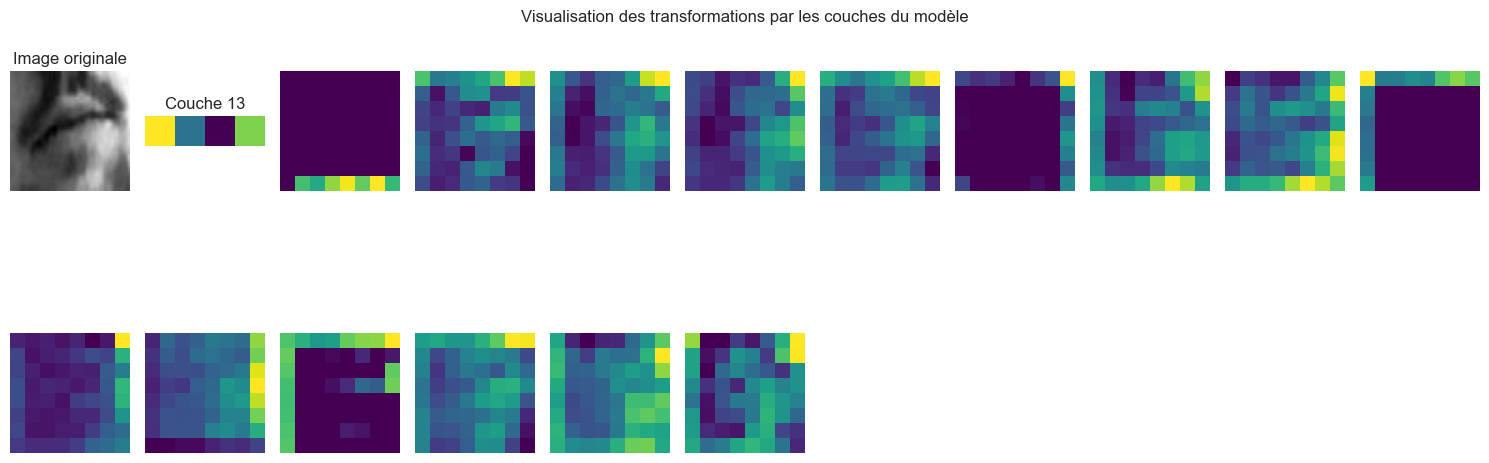

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


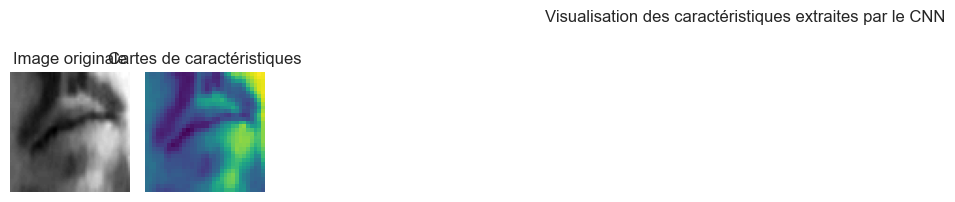

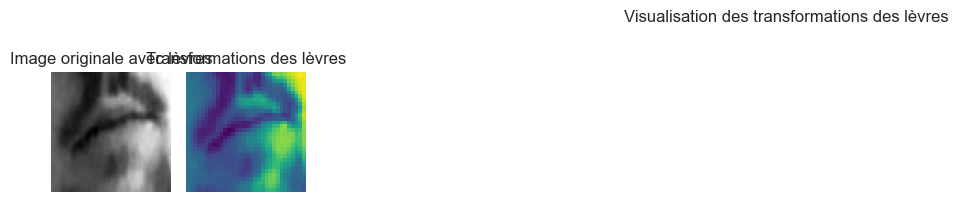

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

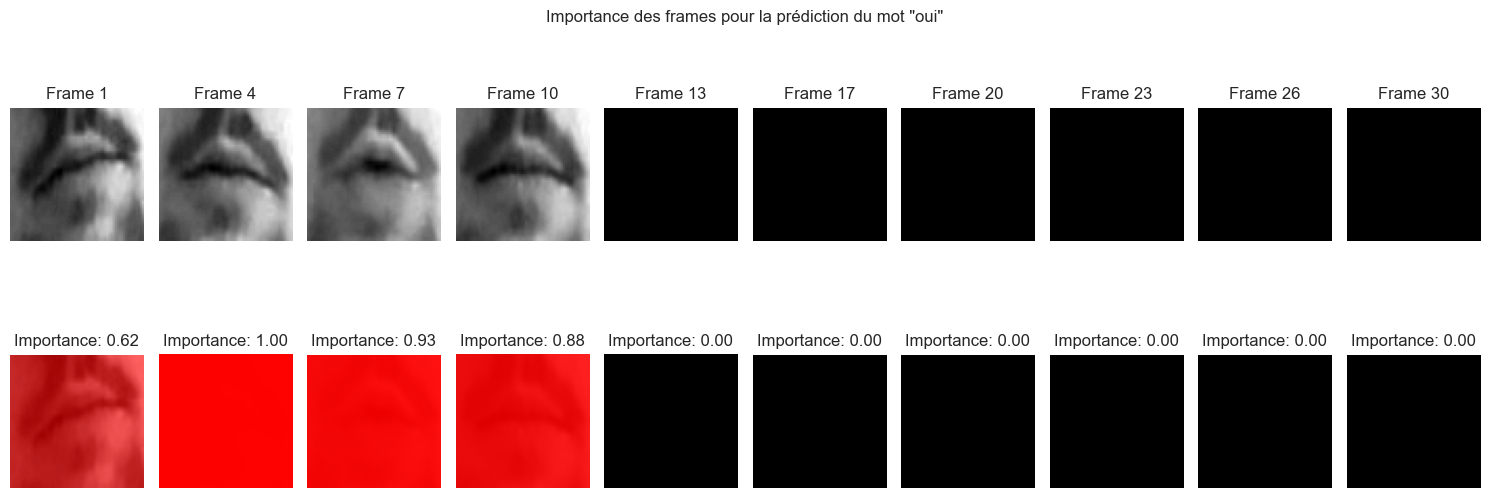

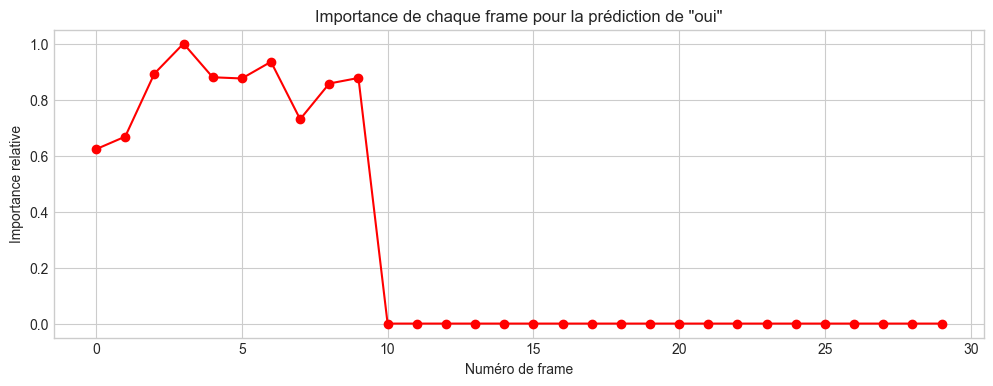

In [22]:
# Ajouter l'import nécessaire
import tensorflow.keras.backend as K

# Exemple d'utilisation:
if len(X_test) > 0:
    # Choisir le mot "un"
    target_word = "oui"
    word_index = target_words.index(target_word)
    # Trouver un exemple de ce mot dans X_test
    for idx in range(len(y_test)):
        if np.argmax(y_test[idx]) == word_index:
            example_sequence = X_test[idx:idx+1]
            example_label = word_index
            break
    print(f"Exemple sélectionné - Mot: {target_words[example_label]}")

    # Visualiser le prétraitement et l'architecture
    visualize_preprocessing_and_architecture(example_sequence)

    # Visualiser les caractéristiques
    visualize_feature_maps(example_sequence)

    # Visualiser l'attention
    visualize_attention(example_sequence, example_label)